In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [8]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -100 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [9]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [11]:

N = 250
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.2
γ = 0.95
ϵ = 0.3
x = [20, 60, 90, 1, 1];
λ = 0.95
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);

epochs = 15000
epochsize = 200

total = 0
rando = 0

last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
u = uu[1]
rando += uu[2]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
        
    if (counter % epochsize == 0) || (xp[1] <= 10)
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current46_3.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 27.5 AVG: 17.51 Epoch: 5117 -----------
--------- CURRENT: 50.0 AVG: 17.52 Epoch: 5118 -----------
--------- CURRENT: -9.25 AVG: 17.51 Epoch: 5119 -----------
--------- CURRENT: 50.0 AVG: 17.52 Epoch: 5120 -----------
--------- CURRENT: 50.0 AVG: 17.53 Epoch: 5121 -----------
--------- CURRENT: 50.0 AVG: 17.53 Epoch: 5122 -----------
--------- CURRENT: 50.0 AVG: 17.54 Epoch: 5123 -----------
--------- CURRENT: 50.0 AVG: 17.54 Epoch: 5124 -----------
--------- CURRENT: 50.0 AVG: 17.55 Epoch: 5125 -----------
--------- CURRENT: 50.0 AVG: 17.56 Epoch: 5126 -----------
--------- CURRENT: 50.0 AVG: 17.56 Epoch: 5127 -----------
--------- CURRENT: 50.0 AVG: 17.57 Epoch: 5128 -----------
--------- CURRENT: 50.0 AVG: 17.57 Epoch: 5129 -----------
--------- CURRENT: 50.0 AVG: 17.58 Epoch: 5130 -----------
--------- CURRENT: 50.0 AVG: 17.59 Epoch: 5131 -----------
--------- CURRENT: 50.0 AVG: 17.59 Epoch: 5132 -----------
--------- CURRENT: 50.0 AVG: 17.6 Epoch: 5133 ---------

--------- CURRENT: 50.0 AVG: 17.72 Epoch: 5248 -----------
--------- CURRENT: -231.5 AVG: 17.68 Epoch: 5248 -----------
--------- CURRENT: 31.25 AVG: 17.68 Epoch: 5249 -----------
--------- CURRENT: 50.0 AVG: 17.69 Epoch: 5250 -----------
--------- CURRENT: 50.0 AVG: 17.69 Epoch: 5251 -----------
--------- CURRENT: 50.0 AVG: 17.7 Epoch: 5252 -----------
--------- CURRENT: 50.0 AVG: 17.7 Epoch: 5253 -----------
--------- CURRENT: -46.0 AVG: 17.69 Epoch: 5254 -----------
--------- CURRENT: 50.0 AVG: 17.7 Epoch: 5255 -----------
--------- CURRENT: 50.0 AVG: 17.7 Epoch: 5256 -----------
--------- CURRENT: 50.0 AVG: 17.71 Epoch: 5257 -----------
--------- CURRENT: -77.5 AVG: 17.69 Epoch: 5258 -----------
--------- CURRENT: -26.5 AVG: 17.68 Epoch: 5259 -----------
--------- CURRENT: 50.0 AVG: 17.69 Epoch: 5260 -----------
--------- CURRENT: 50.0 AVG: 17.7 Epoch: 5261 -----------
--------- CURRENT: -17.5 AVG: 17.69 Epoch: 5262 -----------
--------- CURRENT: 50.0 AVG: 17.69 Epoch: 5263 -------

--------- CURRENT: 3.0 AVG: 17.88 Epoch: 5379 -----------
--------- CURRENT: 50.0 AVG: 17.89 Epoch: 5380 -----------
--------- CURRENT: 50.0 AVG: 17.89 Epoch: 5381 -----------
--------- CURRENT: 50.0 AVG: 17.9 Epoch: 5382 -----------
--------- CURRENT: 50.0 AVG: 17.9 Epoch: 5383 -----------
--------- CURRENT: 50.0 AVG: 17.91 Epoch: 5384 -----------
--------- CURRENT: 50.0 AVG: 17.92 Epoch: 5385 -----------
--------- CURRENT: 50.0 AVG: 17.92 Epoch: 5386 -----------
--------- CURRENT: -245.2 AVG: 17.88 Epoch: 5386 -----------
--------- CURRENT: -83.25 AVG: 17.86 Epoch: 5387 -----------
--------- CURRENT: -90.25 AVG: 17.84 Epoch: 5388 -----------
--------- CURRENT: 50.0 AVG: 17.84 Epoch: 5389 -----------
--------- CURRENT: -6.25 AVG: 17.84 Epoch: 5390 -----------
--------- CURRENT: 50.0 AVG: 17.85 Epoch: 5391 -----------
--------- CURRENT: 50.0 AVG: 17.85 Epoch: 5392 -----------
--------- CURRENT: 50.0 AVG: 17.86 Epoch: 5393 -----------
--------- CURRENT: 50.0 AVG: 17.86 Epoch: 5394 -----

--------- CURRENT: 50.0 AVG: 18.0 Epoch: 5510 -----------
--------- CURRENT: 50.0 AVG: 18.0 Epoch: 5511 -----------
--------- CURRENT: 35.0 AVG: 18.01 Epoch: 5512 -----------
--------- CURRENT: 50.0 AVG: 18.01 Epoch: 5513 -----------
--------- CURRENT: 50.0 AVG: 18.02 Epoch: 5514 -----------
--------- CURRENT: 50.0 AVG: 18.02 Epoch: 5515 -----------
--------- CURRENT: 50.0 AVG: 18.03 Epoch: 5516 -----------
--------- CURRENT: 50.0 AVG: 18.03 Epoch: 5517 -----------
--------- CURRENT: 50.0 AVG: 18.04 Epoch: 5518 -----------
--------- CURRENT: -230.8 AVG: 18.0 Epoch: 5518 -----------
--------- CURRENT: 30.5 AVG: 18.0 Epoch: 5519 -----------
--------- CURRENT: -228.5 AVG: 17.96 Epoch: 5519 -----------
--------- CURRENT: 28.25 AVG: 17.96 Epoch: 5520 -----------
--------- CURRENT: 50.0 AVG: 17.96 Epoch: 5521 -----------
--------- CURRENT: 50.0 AVG: 17.97 Epoch: 5522 -----------
--------- CURRENT: 50.0 AVG: 17.98 Epoch: 5523 -----------
--------- CURRENT: 50.0 AVG: 17.98 Epoch: 5524 --------

--------- CURRENT: -201.0 AVG: 18.14 Epoch: 5641 -----------
--------- CURRENT: 0.75 AVG: 18.13 Epoch: 5642 -----------
--------- CURRENT: 50.0 AVG: 18.14 Epoch: 5643 -----------
--------- CURRENT: 50.0 AVG: 18.14 Epoch: 5644 -----------
--------- CURRENT: 50.0 AVG: 18.15 Epoch: 5645 -----------
--------- CURRENT: 40.25 AVG: 18.15 Epoch: 5646 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 5647 -----------
--------- CURRENT: -11.5 AVG: 18.15 Epoch: 5648 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 5649 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 5650 -----------
--------- CURRENT: 38.75 AVG: 18.17 Epoch: 5651 -----------
--------- CURRENT: 50.0 AVG: 18.17 Epoch: 5652 -----------
--------- CURRENT: 41.0 AVG: 18.18 Epoch: 5653 -----------
--------- CURRENT: 43.25 AVG: 18.18 Epoch: 5654 -----------
--------- CURRENT: 50.0 AVG: 18.19 Epoch: 5655 -----------
--------- CURRENT: -242.2 AVG: 18.14 Epoch: 5655 -----------
--------- CURRENT: 42.0 AVG: 18.15 Epoch: 5656 -

--------- CURRENT: 50.0 AVG: 18.44 Epoch: 5774 -----------
--------- CURRENT: 50.0 AVG: 18.44 Epoch: 5775 -----------
--------- CURRENT: 50.0 AVG: 18.45 Epoch: 5776 -----------
--------- CURRENT: 50.0 AVG: 18.45 Epoch: 5777 -----------
--------- CURRENT: 50.0 AVG: 18.46 Epoch: 5778 -----------
--------- CURRENT: 50.0 AVG: 18.46 Epoch: 5779 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 5780 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 5781 -----------
--------- CURRENT: 50.0 AVG: 18.48 Epoch: 5782 -----------
--------- CURRENT: -99.25 AVG: 18.46 Epoch: 5783 -----------
--------- CURRENT: 50.0 AVG: 18.46 Epoch: 5784 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 5785 -----------
--------- CURRENT: -85.0 AVG: 18.45 Epoch: 5786 -----------
--------- CURRENT: 50.0 AVG: 18.46 Epoch: 5787 -----------
--------- CURRENT: 50.0 AVG: 18.46 Epoch: 5788 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 5789 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 5790 ------

--------- CURRENT: 50.0 AVG: 18.64 Epoch: 5908 -----------
--------- CURRENT: 11.0 AVG: 18.64 Epoch: 5909 -----------
--------- CURRENT: 50.0 AVG: 18.64 Epoch: 5910 -----------
--------- CURRENT: 50.0 AVG: 18.65 Epoch: 5911 -----------
--------- CURRENT: 50.0 AVG: 18.65 Epoch: 5912 -----------
--------- CURRENT: 28.25 AVG: 18.65 Epoch: 5913 -----------
--------- CURRENT: 50.0 AVG: 18.66 Epoch: 5914 -----------
--------- CURRENT: -244.8 AVG: 18.62 Epoch: 5914 -----------
--------- CURRENT: 44.5 AVG: 18.62 Epoch: 5915 -----------
--------- CURRENT: 50.0 AVG: 18.63 Epoch: 5916 -----------
--------- CURRENT: 50.0 AVG: 18.63 Epoch: 5917 -----------
--------- CURRENT: 50.0 AVG: 18.64 Epoch: 5918 -----------
--------- CURRENT: 50.0 AVG: 18.64 Epoch: 5919 -----------
--------- CURRENT: 29.75 AVG: 18.64 Epoch: 5920 -----------
--------- CURRENT: -243.2 AVG: 18.6 Epoch: 5920 -----------
--------- CURRENT: 43.0 AVG: 18.6 Epoch: 5921 -----------
--------- CURRENT: -202.0 AVG: 18.57 Epoch: 5921 ---

--------- CURRENT: 50.0 AVG: 18.78 Epoch: 6041 -----------
--------- CURRENT: 50.0 AVG: 18.79 Epoch: 6042 -----------
--------- CURRENT: 50.0 AVG: 18.79 Epoch: 6043 -----------
--------- CURRENT: 50.0 AVG: 18.8 Epoch: 6044 -----------
--------- CURRENT: 50.0 AVG: 18.8 Epoch: 6045 -----------
--------- CURRENT: 50.0 AVG: 18.8 Epoch: 6046 -----------
--------- CURRENT: 50.0 AVG: 18.81 Epoch: 6047 -----------
--------- CURRENT: 50.0 AVG: 18.81 Epoch: 6048 -----------
--------- CURRENT: 50.0 AVG: 18.82 Epoch: 6049 -----------
--------- CURRENT: -4.0 AVG: 18.82 Epoch: 6050 -----------
--------- CURRENT: 50.0 AVG: 18.82 Epoch: 6051 -----------
--------- CURRENT: -43.0 AVG: 18.81 Epoch: 6052 -----------
--------- CURRENT: 50.0 AVG: 18.82 Epoch: 6053 -----------
--------- CURRENT: 50.0 AVG: 18.82 Epoch: 6054 -----------
--------- CURRENT: -97.0 AVG: 18.8 Epoch: 6055 -----------
--------- CURRENT: 50.0 AVG: 18.81 Epoch: 6056 -----------
--------- CURRENT: 50.0 AVG: 18.81 Epoch: 6057 -----------

--------- CURRENT: 36.5 AVG: 19.04 Epoch: 6175 -----------
--------- CURRENT: 50.0 AVG: 19.04 Epoch: 6176 -----------
--------- CURRENT: 50.0 AVG: 19.05 Epoch: 6177 -----------
--------- CURRENT: -212.3 AVG: 19.01 Epoch: 6177 -----------
--------- CURRENT: 12.0 AVG: 19.01 Epoch: 6178 -----------
--------- CURRENT: 50.0 AVG: 19.01 Epoch: 6179 -----------
--------- CURRENT: 50.0 AVG: 19.02 Epoch: 6180 -----------
--------- CURRENT: 50.0 AVG: 19.02 Epoch: 6181 -----------
--------- CURRENT: 47.0 AVG: 19.03 Epoch: 6182 -----------
--------- CURRENT: -82.75 AVG: 19.01 Epoch: 6183 -----------
--------- CURRENT: 50.0 AVG: 19.02 Epoch: 6184 -----------
--------- CURRENT: 50.0 AVG: 19.02 Epoch: 6185 -----------
--------- CURRENT: 50.0 AVG: 19.03 Epoch: 6186 -----------
--------- CURRENT: 50.0 AVG: 19.03 Epoch: 6187 -----------
--------- CURRENT: -225.8 AVG: 18.99 Epoch: 6187 -----------
--------- CURRENT: 25.5 AVG: 19.0 Epoch: 6188 -----------
--------- CURRENT: 34.25 AVG: 19.0 Epoch: 6189 ----

--------- CURRENT: 50.0 AVG: 19.18 Epoch: 6307 -----------
--------- CURRENT: 50.0 AVG: 19.18 Epoch: 6308 -----------
--------- CURRENT: 41.75 AVG: 19.18 Epoch: 6309 -----------
--------- CURRENT: 50.0 AVG: 19.19 Epoch: 6310 -----------
--------- CURRENT: 50.0 AVG: 19.19 Epoch: 6311 -----------
--------- CURRENT: 30.5 AVG: 19.2 Epoch: 6312 -----------
--------- CURRENT: 50.0 AVG: 19.2 Epoch: 6313 -----------
--------- CURRENT: 50.0 AVG: 19.2 Epoch: 6314 -----------
--------- CURRENT: 50.0 AVG: 19.21 Epoch: 6315 -----------
--------- CURRENT: 50.0 AVG: 19.21 Epoch: 6316 -----------
--------- CURRENT: 50.0 AVG: 19.22 Epoch: 6317 -----------
--------- CURRENT: 50.0 AVG: 19.22 Epoch: 6318 -----------
--------- CURRENT: 50.0 AVG: 19.23 Epoch: 6319 -----------
--------- CURRENT: 50.0 AVG: 19.23 Epoch: 6320 -----------
--------- CURRENT: 50.0 AVG: 19.24 Epoch: 6321 -----------
--------- CURRENT: -13.75 AVG: 19.23 Epoch: 6322 -----------
--------- CURRENT: 50.0 AVG: 19.24 Epoch: 6323 ---------

--------- CURRENT: 50.0 AVG: 19.37 Epoch: 6442 -----------
--------- CURRENT: -215.8 AVG: 19.33 Epoch: 6442 -----------
--------- CURRENT: 15.5 AVG: 19.33 Epoch: 6443 -----------
--------- CURRENT: 50.0 AVG: 19.34 Epoch: 6444 -----------
--------- CURRENT: 26.0 AVG: 19.34 Epoch: 6445 -----------
--------- CURRENT: 50.0 AVG: 19.34 Epoch: 6446 -----------
--------- CURRENT: 50.0 AVG: 19.35 Epoch: 6447 -----------
--------- CURRENT: -1.0 AVG: 19.35 Epoch: 6448 -----------
--------- CURRENT: 50.0 AVG: 19.35 Epoch: 6449 -----------
--------- CURRENT: -228.5 AVG: 19.31 Epoch: 6449 -----------
--------- CURRENT: 28.25 AVG: 19.32 Epoch: 6450 -----------
--------- CURRENT: 50.0 AVG: 19.32 Epoch: 6451 -----------
--------- CURRENT: 50.0 AVG: 19.32 Epoch: 6452 -----------
--------- CURRENT: 50.0 AVG: 19.33 Epoch: 6453 -----------
--------- CURRENT: 50.0 AVG: 19.33 Epoch: 6454 -----------
--------- CURRENT: 50.0 AVG: 19.34 Epoch: 6455 -----------
--------- CURRENT: 50.0 AVG: 19.34 Epoch: 6456 ----

--------- CURRENT: 50.0 AVG: 19.28 Epoch: 6571 -----------
--------- CURRENT: 44.0 AVG: 19.28 Epoch: 6572 -----------
--------- CURRENT: 50.0 AVG: 19.29 Epoch: 6573 -----------
--------- CURRENT: 26.75 AVG: 19.29 Epoch: 6574 -----------
--------- CURRENT: 50.0 AVG: 19.29 Epoch: 6575 -----------
--------- CURRENT: -248.2 AVG: 19.26 Epoch: 6575 -----------
--------- CURRENT: 18.75 AVG: 19.26 Epoch: 6576 -----------
--------- CURRENT: -48.25 AVG: 19.25 Epoch: 6577 -----------
--------- CURRENT: 44.0 AVG: 19.25 Epoch: 6578 -----------
--------- CURRENT: 50.0 AVG: 19.25 Epoch: 6579 -----------
--------- CURRENT: 50.0 AVG: 19.26 Epoch: 6580 -----------
--------- CURRENT: 50.0 AVG: 19.26 Epoch: 6581 -----------
--------- CURRENT: 50.0 AVG: 19.27 Epoch: 6582 -----------
--------- CURRENT: 50.0 AVG: 19.27 Epoch: 6583 -----------
--------- CURRENT: -82.0 AVG: 19.26 Epoch: 6584 -----------
--------- CURRENT: 50.0 AVG: 19.26 Epoch: 6585 -----------
--------- CURRENT: -77.5 AVG: 19.25 Epoch: 6586 -

--------- CURRENT: 50.0 AVG: 19.07 Epoch: 6702 -----------
--------- CURRENT: -79.0 AVG: 19.05 Epoch: 6703 -----------
--------- CURRENT: -217.3 AVG: 19.02 Epoch: 6703 -----------
--------- CURRENT: 17.0 AVG: 19.02 Epoch: 6704 -----------
--------- CURRENT: 50.0 AVG: 19.02 Epoch: 6705 -----------
--------- CURRENT: 50.0 AVG: 19.03 Epoch: 6706 -----------
--------- CURRENT: 50.0 AVG: 19.03 Epoch: 6707 -----------
--------- CURRENT: -13.75 AVG: 19.03 Epoch: 6708 -----------
--------- CURRENT: 50.0 AVG: 19.03 Epoch: 6709 -----------
--------- CURRENT: -97.75 AVG: 19.02 Epoch: 6710 -----------
--------- CURRENT: -49.75 AVG: 19.01 Epoch: 6711 -----------
--------- CURRENT: 50.0 AVG: 19.01 Epoch: 6712 -----------
--------- CURRENT: -28.75 AVG: 19.0 Epoch: 6713 -----------
--------- CURRENT: 50.0 AVG: 19.01 Epoch: 6714 -----------
--------- CURRENT: 50.0 AVG: 19.01 Epoch: 6715 -----------
--------- CURRENT: 50.0 AVG: 19.02 Epoch: 6716 -----------
--------- CURRENT: 50.0 AVG: 19.02 Epoch: 6717

--------- CURRENT: 50.0 AVG: 19.04 Epoch: 6835 -----------
--------- CURRENT: 50.0 AVG: 19.04 Epoch: 6836 -----------
--------- CURRENT: -46.75 AVG: 19.03 Epoch: 6837 -----------
--------- CURRENT: 50.0 AVG: 19.04 Epoch: 6838 -----------
--------- CURRENT: 34.25 AVG: 19.04 Epoch: 6839 -----------
--------- CURRENT: 50.0 AVG: 19.04 Epoch: 6840 -----------
--------- CURRENT: 50.0 AVG: 19.05 Epoch: 6841 -----------
--------- CURRENT: 14.0 AVG: 19.05 Epoch: 6842 -----------
--------- CURRENT: 1.25 AVG: 19.05 Epoch: 6843 -----------
--------- CURRENT: -220.5 AVG: 19.01 Epoch: 6843 -----------
--------- CURRENT: -21.75 AVG: 19.01 Epoch: 6844 -----------
--------- CURRENT: 50.0 AVG: 19.01 Epoch: 6845 -----------
--------- CURRENT: -76.0 AVG: 19.0 Epoch: 6846 -----------
--------- CURRENT: 50.0 AVG: 19.0 Epoch: 6847 -----------
--------- CURRENT: 50.0 AVG: 19.01 Epoch: 6848 -----------
--------- CURRENT: 50.0 AVG: 19.01 Epoch: 6849 -----------
--------- CURRENT: -40.75 AVG: 19.0 Epoch: 6850 --

--------- CURRENT: 50.0 AVG: 18.96 Epoch: 6969 -----------
--------- CURRENT: 50.0 AVG: 18.96 Epoch: 6970 -----------
--------- CURRENT: 50.0 AVG: 18.97 Epoch: 6971 -----------
--------- CURRENT: -61.75 AVG: 18.96 Epoch: 6972 -----------
--------- CURRENT: -24.25 AVG: 18.95 Epoch: 6973 -----------
--------- CURRENT: 50.0 AVG: 18.95 Epoch: 6974 -----------
--------- CURRENT: -67.75 AVG: 18.94 Epoch: 6975 -----------
--------- CURRENT: 50.0 AVG: 18.95 Epoch: 6976 -----------
--------- CURRENT: -25.0 AVG: 18.94 Epoch: 6977 -----------
--------- CURRENT: 20.0 AVG: 18.94 Epoch: 6978 -----------
--------- CURRENT: -245.0 AVG: 18.91 Epoch: 6978 -----------
--------- CURRENT: 44.75 AVG: 18.91 Epoch: 6979 -----------
--------- CURRENT: 50.0 AVG: 18.91 Epoch: 6980 -----------
--------- CURRENT: 1.25 AVG: 18.91 Epoch: 6981 -----------
--------- CURRENT: 50.0 AVG: 18.92 Epoch: 6982 -----------
--------- CURRENT: -0.25 AVG: 18.91 Epoch: 6983 -----------
--------- CURRENT: 30.5 AVG: 18.91 Epoch: 698

--------- CURRENT: -100.0 AVG: 18.87 Epoch: 7104 -----------
--------- CURRENT: 10.25 AVG: 18.87 Epoch: 7105 -----------
--------- CURRENT: 50.0 AVG: 18.87 Epoch: 7106 -----------
--------- CURRENT: 50.0 AVG: 18.87 Epoch: 7107 -----------
--------- CURRENT: 50.0 AVG: 18.88 Epoch: 7108 -----------
--------- CURRENT: 44.75 AVG: 18.88 Epoch: 7109 -----------
--------- CURRENT: -53.5 AVG: 18.87 Epoch: 7110 -----------
--------- CURRENT: -79.75 AVG: 18.86 Epoch: 7111 -----------
--------- CURRENT: 50.0 AVG: 18.86 Epoch: 7112 -----------
--------- CURRENT: 27.5 AVG: 18.86 Epoch: 7113 -----------
--------- CURRENT: -26.5 AVG: 18.86 Epoch: 7114 -----------
--------- CURRENT: 50.0 AVG: 18.86 Epoch: 7115 -----------
--------- CURRENT: 50.0 AVG: 18.87 Epoch: 7116 -----------
--------- CURRENT: -244.0 AVG: 18.83 Epoch: 7116 -----------
--------- CURRENT: -25.25 AVG: 18.82 Epoch: 7117 -----------
--------- CURRENT: -71.5 AVG: 18.81 Epoch: 7118 -----------
--------- CURRENT: 4.25 AVG: 18.81 Epoch: 7

--------- CURRENT: -80.5 AVG: 18.7 Epoch: 7238 -----------
--------- CURRENT: 42.5 AVG: 18.7 Epoch: 7239 -----------
--------- CURRENT: 50.0 AVG: 18.71 Epoch: 7240 -----------
--------- CURRENT: 50.0 AVG: 18.71 Epoch: 7241 -----------
--------- CURRENT: 50.0 AVG: 18.72 Epoch: 7242 -----------
--------- CURRENT: 50.0 AVG: 18.72 Epoch: 7243 -----------
--------- CURRENT: 36.5 AVG: 18.72 Epoch: 7244 -----------
--------- CURRENT: 50.0 AVG: 18.73 Epoch: 7245 -----------
--------- CURRENT: 50.0 AVG: 18.73 Epoch: 7246 -----------
--------- CURRENT: 50.0 AVG: 18.73 Epoch: 7247 -----------
--------- CURRENT: 50.0 AVG: 18.74 Epoch: 7248 -----------
--------- CURRENT: 7.25 AVG: 18.74 Epoch: 7249 -----------
--------- CURRENT: -245.8 AVG: 18.7 Epoch: 7249 -----------
--------- CURRENT: -71.5 AVG: 18.69 Epoch: 7250 -----------
--------- CURRENT: 50.0 AVG: 18.69 Epoch: 7251 -----------
--------- CURRENT: -67.75 AVG: 18.68 Epoch: 7252 -----------
--------- CURRENT: 50.0 AVG: 18.69 Epoch: 7253 ------

--------- CURRENT: 28.75 AVG: 18.63 Epoch: 7370 -----------
--------- CURRENT: -89.5 AVG: 18.61 Epoch: 7371 -----------
--------- CURRENT: 50.0 AVG: 18.62 Epoch: 7372 -----------
--------- CURRENT: -70.75 AVG: 18.6 Epoch: 7373 -----------
--------- CURRENT: 50.0 AVG: 18.61 Epoch: 7374 -----------
--------- CURRENT: 50.0 AVG: 18.61 Epoch: 7375 -----------
--------- CURRENT: 32.75 AVG: 18.61 Epoch: 7376 -----------
--------- CURRENT: 14.0 AVG: 18.61 Epoch: 7377 -----------
--------- CURRENT: 46.25 AVG: 18.62 Epoch: 7378 -----------
--------- CURRENT: 50.0 AVG: 18.62 Epoch: 7379 -----------
--------- CURRENT: -13.0 AVG: 18.62 Epoch: 7380 -----------
--------- CURRENT: -63.25 AVG: 18.61 Epoch: 7381 -----------
--------- CURRENT: -247.8 AVG: 18.57 Epoch: 7381 -----------
--------- CURRENT: 47.5 AVG: 18.58 Epoch: 7382 -----------
--------- CURRENT: 50.0 AVG: 18.58 Epoch: 7383 -----------
--------- CURRENT: -82.0 AVG: 18.57 Epoch: 7384 -----------
--------- CURRENT: 50.0 AVG: 18.57 Epoch: 738

--------- CURRENT: 50.0 AVG: 18.47 Epoch: 7504 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 7505 -----------
--------- CURRENT: -30.25 AVG: 18.47 Epoch: 7506 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 7507 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 7508 -----------
--------- CURRENT: -78.25 AVG: 18.46 Epoch: 7509 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 7510 -----------
--------- CURRENT: -20.5 AVG: 18.46 Epoch: 7511 -----------
--------- CURRENT: 50.0 AVG: 18.46 Epoch: 7512 -----------
--------- CURRENT: 38.0 AVG: 18.47 Epoch: 7513 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 7514 -----------
--------- CURRENT: 50.0 AVG: 18.48 Epoch: 7515 -----------
--------- CURRENT: -25.75 AVG: 18.47 Epoch: 7516 -----------
--------- CURRENT: 50.0 AVG: 18.47 Epoch: 7517 -----------
--------- CURRENT: 50.0 AVG: 18.48 Epoch: 7518 -----------
--------- CURRENT: 50.0 AVG: 18.48 Epoch: 7519 -----------
--------- CURRENT: -46.75 AVG: 18.47 Epoch: 7520 

--------- CURRENT: 50.0 AVG: 18.42 Epoch: 7639 -----------
--------- CURRENT: -25.75 AVG: 18.42 Epoch: 7640 -----------
--------- CURRENT: 48.5 AVG: 18.42 Epoch: 7641 -----------
--------- CURRENT: -53.5 AVG: 18.41 Epoch: 7642 -----------
--------- CURRENT: 50.0 AVG: 18.42 Epoch: 7643 -----------
--------- CURRENT: 41.75 AVG: 18.42 Epoch: 7644 -----------
--------- CURRENT: 50.0 AVG: 18.42 Epoch: 7645 -----------
--------- CURRENT: 50.0 AVG: 18.43 Epoch: 7646 -----------
--------- CURRENT: 50.0 AVG: 18.43 Epoch: 7647 -----------
--------- CURRENT: 50.0 AVG: 18.44 Epoch: 7648 -----------
--------- CURRENT: 50.0 AVG: 18.44 Epoch: 7649 -----------
--------- CURRENT: 50.0 AVG: 18.44 Epoch: 7650 -----------
--------- CURRENT: 14.75 AVG: 18.44 Epoch: 7651 -----------
--------- CURRENT: 50.0 AVG: 18.45 Epoch: 7652 -----------
--------- CURRENT: 50.0 AVG: 18.45 Epoch: 7653 -----------
--------- CURRENT: -74.5 AVG: 18.44 Epoch: 7654 -----------
--------- CURRENT: 33.5 AVG: 18.44 Epoch: 7655 ---

--------- CURRENT: 50.0 AVG: 18.25 Epoch: 7772 -----------
--------- CURRENT: -16.0 AVG: 18.24 Epoch: 7773 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 7774 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 7775 -----------
--------- CURRENT: 50.0 AVG: 18.26 Epoch: 7776 -----------
--------- CURRENT: 4.25 AVG: 18.25 Epoch: 7777 -----------
--------- CURRENT: 50.0 AVG: 18.26 Epoch: 7778 -----------
--------- CURRENT: 50.0 AVG: 18.26 Epoch: 7779 -----------
--------- CURRENT: 50.0 AVG: 18.27 Epoch: 7780 -----------
--------- CURRENT: 47.75 AVG: 18.27 Epoch: 7781 -----------
--------- CURRENT: 50.0 AVG: 18.27 Epoch: 7782 -----------
--------- CURRENT: 44.0 AVG: 18.28 Epoch: 7783 -----------
--------- CURRENT: 50.0 AVG: 18.28 Epoch: 7784 -----------
--------- CURRENT: 50.0 AVG: 18.28 Epoch: 7785 -----------
--------- CURRENT: 50.0 AVG: 18.29 Epoch: 7786 -----------
--------- CURRENT: 48.5 AVG: 18.29 Epoch: 7787 -----------
--------- CURRENT: 18.5 AVG: 18.29 Epoch: 7788 -------

--------- CURRENT: 50.0 AVG: 18.19 Epoch: 7905 -----------
--------- CURRENT: 50.0 AVG: 18.2 Epoch: 7906 -----------
--------- CURRENT: 41.75 AVG: 18.2 Epoch: 7907 -----------
--------- CURRENT: -61.0 AVG: 18.19 Epoch: 7908 -----------
--------- CURRENT: 32.0 AVG: 18.19 Epoch: 7909 -----------
--------- CURRENT: 17.0 AVG: 18.19 Epoch: 7910 -----------
--------- CURRENT: 50.0 AVG: 18.19 Epoch: 7911 -----------
--------- CURRENT: 50.0 AVG: 18.2 Epoch: 7912 -----------
--------- CURRENT: 43.25 AVG: 18.2 Epoch: 7913 -----------
--------- CURRENT: 50.0 AVG: 18.21 Epoch: 7914 -----------
--------- CURRENT: 50.0 AVG: 18.21 Epoch: 7915 -----------
--------- CURRENT: 16.25 AVG: 18.21 Epoch: 7916 -----------
--------- CURRENT: -63.25 AVG: 18.2 Epoch: 7917 -----------
--------- CURRENT: -20.5 AVG: 18.19 Epoch: 7918 -----------
--------- CURRENT: 47.0 AVG: 18.2 Epoch: 7919 -----------
--------- CURRENT: 14.0 AVG: 18.2 Epoch: 7920 -----------
--------- CURRENT: -92.5 AVG: 18.18 Epoch: 7921 --------

--------- CURRENT: -247.2 AVG: 18.26 Epoch: 8043 -----------
--------- CURRENT: -68.5 AVG: 18.25 Epoch: 8044 -----------
--------- CURRENT: 15.5 AVG: 18.25 Epoch: 8045 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 8046 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 8047 -----------
--------- CURRENT: 50.0 AVG: 18.26 Epoch: 8048 -----------
--------- CURRENT: 28.25 AVG: 18.26 Epoch: 8049 -----------
--------- CURRENT: 50.0 AVG: 18.26 Epoch: 8050 -----------
--------- CURRENT: 50.0 AVG: 18.27 Epoch: 8051 -----------
--------- CURRENT: 50.0 AVG: 18.27 Epoch: 8052 -----------
--------- CURRENT: 32.75 AVG: 18.27 Epoch: 8053 -----------
--------- CURRENT: 50.0 AVG: 18.28 Epoch: 8054 -----------
--------- CURRENT: -93.25 AVG: 18.26 Epoch: 8055 -----------
--------- CURRENT: -247.5 AVG: 18.23 Epoch: 8055 -----------
--------- CURRENT: 47.25 AVG: 18.23 Epoch: 8056 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 8057 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 8058

--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8177 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8178 -----------
--------- CURRENT: -13.0 AVG: 18.22 Epoch: 8179 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8180 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8181 -----------
--------- CURRENT: 44.0 AVG: 18.23 Epoch: 8182 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8183 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8184 -----------
--------- CURRENT: 45.5 AVG: 18.24 Epoch: 8185 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 8186 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 8187 -----------
--------- CURRENT: 7.25 AVG: 18.24 Epoch: 8188 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 8189 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 8190 -----------
--------- CURRENT: -100.0 AVG: 18.24 Epoch: 8191 -----------
--------- CURRENT: -47.5 AVG: 18.23 Epoch: 8192 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8193 -----

--------- CURRENT: -82.0 AVG: 18.18 Epoch: 8313 -----------
--------- CURRENT: 35.75 AVG: 18.19 Epoch: 8314 -----------
--------- CURRENT: -16.0 AVG: 18.18 Epoch: 8315 -----------
--------- CURRENT: 50.0 AVG: 18.19 Epoch: 8316 -----------
--------- CURRENT: -4.0 AVG: 18.18 Epoch: 8317 -----------
--------- CURRENT: 50.0 AVG: 18.19 Epoch: 8318 -----------
--------- CURRENT: 17.0 AVG: 18.19 Epoch: 8319 -----------
--------- CURRENT: -56.5 AVG: 18.18 Epoch: 8320 -----------
--------- CURRENT: 50.0 AVG: 18.18 Epoch: 8321 -----------
--------- CURRENT: 50.0 AVG: 18.18 Epoch: 8322 -----------
--------- CURRENT: 24.5 AVG: 18.19 Epoch: 8323 -----------
--------- CURRENT: 50.0 AVG: 18.19 Epoch: 8324 -----------
--------- CURRENT: -61.0 AVG: 18.18 Epoch: 8325 -----------
--------- CURRENT: -27.25 AVG: 18.18 Epoch: 8326 -----------
--------- CURRENT: -66.25 AVG: 18.17 Epoch: 8327 -----------
--------- CURRENT: -98.5 AVG: 18.15 Epoch: 8328 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 8329

--------- CURRENT: 27.5 AVG: 18.2 Epoch: 8450 -----------
--------- CURRENT: 37.25 AVG: 18.2 Epoch: 8451 -----------
--------- CURRENT: 50.0 AVG: 18.21 Epoch: 8452 -----------
--------- CURRENT: 50.0 AVG: 18.21 Epoch: 8453 -----------
--------- CURRENT: 26.75 AVG: 18.21 Epoch: 8454 -----------
--------- CURRENT: 39.5 AVG: 18.21 Epoch: 8455 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8456 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8457 -----------
--------- CURRENT: -63.25 AVG: 18.21 Epoch: 8458 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8459 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8460 -----------
--------- CURRENT: -16.75 AVG: 18.22 Epoch: 8461 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8462 -----------
--------- CURRENT: 20.0 AVG: 18.22 Epoch: 8463 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8464 -----------
--------- CURRENT: -13.0 AVG: 18.22 Epoch: 8465 -----------
--------- CURRENT: -8.5 AVG: 18.22 Epoch: 8466 ----

--------- CURRENT: 29.75 AVG: 18.16 Epoch: 8588 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 8589 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 8590 -----------
--------- CURRENT: -21.25 AVG: 18.16 Epoch: 8591 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 8592 -----------
--------- CURRENT: 44.0 AVG: 18.17 Epoch: 8593 -----------
--------- CURRENT: 48.5 AVG: 18.17 Epoch: 8594 -----------
--------- CURRENT: 22.25 AVG: 18.17 Epoch: 8595 -----------
--------- CURRENT: 20.75 AVG: 18.17 Epoch: 8596 -----------
--------- CURRENT: 50.0 AVG: 18.17 Epoch: 8597 -----------
--------- CURRENT: -43.0 AVG: 18.17 Epoch: 8598 -----------
--------- CURRENT: 35.0 AVG: 18.17 Epoch: 8599 -----------
--------- CURRENT: -43.75 AVG: 18.16 Epoch: 8600 -----------
--------- CURRENT: -7.0 AVG: 18.16 Epoch: 8601 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 8602 -----------
--------- CURRENT: -32.5 AVG: 18.16 Epoch: 8603 -----------
--------- CURRENT: 50.0 AVG: 18.16 Epoch: 8604 

--------- CURRENT: 50.0 AVG: 18.21 Epoch: 8725 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8726 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8727 -----------
--------- CURRENT: 50.0 AVG: 18.22 Epoch: 8728 -----------
--------- CURRENT: 15.5 AVG: 18.22 Epoch: 8729 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8730 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8731 -----------
--------- CURRENT: 47.0 AVG: 18.23 Epoch: 8732 -----------
--------- CURRENT: -37.75 AVG: 18.23 Epoch: 8733 -----------
--------- CURRENT: -3.25 AVG: 18.22 Epoch: 8734 -----------
--------- CURRENT: 45.5 AVG: 18.23 Epoch: 8735 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8736 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8737 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 8738 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 8739 -----------
--------- CURRENT: -91.0 AVG: 18.23 Epoch: 8740 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 8741 -----

--------- CURRENT: 50.0 AVG: 18.39 Epoch: 8860 -----------
--------- CURRENT: 50.0 AVG: 18.39 Epoch: 8861 -----------
--------- CURRENT: 50.0 AVG: 18.4 Epoch: 8862 -----------
--------- CURRENT: 50.0 AVG: 18.4 Epoch: 8863 -----------
--------- CURRENT: -57.25 AVG: 18.39 Epoch: 8864 -----------
--------- CURRENT: -20.5 AVG: 18.39 Epoch: 8865 -----------
--------- CURRENT: 50.0 AVG: 18.39 Epoch: 8866 -----------
--------- CURRENT: -212.8 AVG: 18.37 Epoch: 8866 -----------
--------- CURRENT: 12.5 AVG: 18.37 Epoch: 8867 -----------
--------- CURRENT: -11.5 AVG: 18.36 Epoch: 8868 -----------
--------- CURRENT: 50.0 AVG: 18.37 Epoch: 8869 -----------
--------- CURRENT: 50.0 AVG: 18.37 Epoch: 8870 -----------
--------- CURRENT: 50.0 AVG: 18.37 Epoch: 8871 -----------
--------- CURRENT: 50.0 AVG: 18.38 Epoch: 8872 -----------
--------- CURRENT: -16.75 AVG: 18.37 Epoch: 8873 -----------
--------- CURRENT: 50.0 AVG: 18.38 Epoch: 8874 -----------
--------- CURRENT: 50.0 AVG: 18.38 Epoch: 8875 ---

--------- CURRENT: 50.0 AVG: 18.48 Epoch: 8993 -----------
--------- CURRENT: 50.0 AVG: 18.49 Epoch: 8994 -----------
--------- CURRENT: 50.0 AVG: 18.49 Epoch: 8995 -----------
--------- CURRENT: 20.75 AVG: 18.49 Epoch: 8996 -----------
--------- CURRENT: 50.0 AVG: 18.49 Epoch: 8997 -----------
--------- CURRENT: 50.0 AVG: 18.5 Epoch: 8998 -----------
--------- CURRENT: 48.5 AVG: 18.5 Epoch: 8999 -----------
--------- CURRENT: 16.25 AVG: 18.5 Epoch: 9000 -----------
--------- CURRENT: -3.25 AVG: 18.5 Epoch: 9001 -----------
--------- CURRENT: 20.75 AVG: 18.5 Epoch: 9002 -----------
--------- CURRENT: 47.0 AVG: 18.5 Epoch: 9003 -----------
--------- CURRENT: 50.0 AVG: 18.5 Epoch: 9004 -----------
--------- CURRENT: -241.8 AVG: 18.48 Epoch: 9004 -----------
--------- CURRENT: 41.5 AVG: 18.48 Epoch: 9005 -----------
--------- CURRENT: 50.0 AVG: 18.48 Epoch: 9006 -----------
--------- CURRENT: 50.0 AVG: 18.48 Epoch: 9007 -----------
--------- CURRENT: -73.0 AVG: 18.48 Epoch: 9008 ---------

--------- CURRENT: 7.0 AVG: 18.26 Epoch: 9116 -----------
--------- CURRENT: -224.0 AVG: 18.23 Epoch: 9116 -----------
--------- CURRENT: 8.75 AVG: 18.23 Epoch: 9117 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 9118 -----------
--------- CURRENT: 8.75 AVG: 18.23 Epoch: 9119 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 9120 -----------
--------- CURRENT: 20.0 AVG: 18.24 Epoch: 9121 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 9122 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 9123 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 9124 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 9125 -----------
--------- CURRENT: 50.0 AVG: 18.25 Epoch: 9126 -----------
--------- CURRENT: 50.0 AVG: 18.26 Epoch: 9127 -----------
--------- CURRENT: -247.2 AVG: 18.23 Epoch: 9127 -----------
--------- CURRENT: 34.25 AVG: 18.23 Epoch: 9128 -----------
--------- CURRENT: 50.0 AVG: 18.23 Epoch: 9129 -----------
--------- CURRENT: 50.0 AVG: 18.24 Epoch: 9130 -----

--------- CURRENT: 50.0 AVG: 18.05 Epoch: 9238 -----------
--------- CURRENT: 50.0 AVG: 18.05 Epoch: 9239 -----------
--------- CURRENT: -245.0 AVG: 18.03 Epoch: 9239 -----------
--------- CURRENT: -58.0 AVG: 18.02 Epoch: 9240 -----------
--------- CURRENT: 50.0 AVG: 18.02 Epoch: 9241 -----------
--------- CURRENT: 50.0 AVG: 18.03 Epoch: 9242 -----------
--------- CURRENT: 50.0 AVG: 18.03 Epoch: 9243 -----------
--------- CURRENT: 50.0 AVG: 18.03 Epoch: 9244 -----------
--------- CURRENT: 50.0 AVG: 18.04 Epoch: 9245 -----------
--------- CURRENT: 50.0 AVG: 18.04 Epoch: 9246 -----------
--------- CURRENT: 50.0 AVG: 18.04 Epoch: 9247 -----------
--------- CURRENT: -48.25 AVG: 18.04 Epoch: 9248 -----------
--------- CURRENT: 50.0 AVG: 18.04 Epoch: 9249 -----------
--------- CURRENT: 34.25 AVG: 18.04 Epoch: 9250 -----------
--------- CURRENT: 50.0 AVG: 18.04 Epoch: 9251 -----------
--------- CURRENT: 50.0 AVG: 18.05 Epoch: 9252 -----------
--------- CURRENT: 24.5 AVG: 18.05 Epoch: 9253 ---

--------- CURRENT: 50.0 AVG: 17.79 Epoch: 9357 -----------
--------- CURRENT: 50.0 AVG: 17.79 Epoch: 9358 -----------
--------- CURRENT: 50.0 AVG: 17.8 Epoch: 9359 -----------
--------- CURRENT: 6.5 AVG: 17.8 Epoch: 9360 -----------
--------- CURRENT: 40.25 AVG: 17.8 Epoch: 9361 -----------
--------- CURRENT: -92.5 AVG: 17.79 Epoch: 9362 -----------
--------- CURRENT: 50.0 AVG: 17.79 Epoch: 9363 -----------
--------- CURRENT: 50.0 AVG: 17.79 Epoch: 9364 -----------
--------- CURRENT: 47.75 AVG: 17.8 Epoch: 9365 -----------
--------- CURRENT: 50.0 AVG: 17.8 Epoch: 9366 -----------
--------- CURRENT: -214.3 AVG: 17.78 Epoch: 9366 -----------
--------- CURRENT: 14.0 AVG: 17.78 Epoch: 9367 -----------
--------- CURRENT: -226.5 AVG: 17.75 Epoch: 9367 -----------
--------- CURRENT: 26.25 AVG: 17.75 Epoch: 9368 -----------
--------- CURRENT: -231.0 AVG: 17.73 Epoch: 9368 -----------
--------- CURRENT: 30.75 AVG: 17.73 Epoch: 9369 -----------
--------- CURRENT: 50.0 AVG: 17.73 Epoch: 9370 ----

In [17]:
#transpose(θ[:,2])*ξ

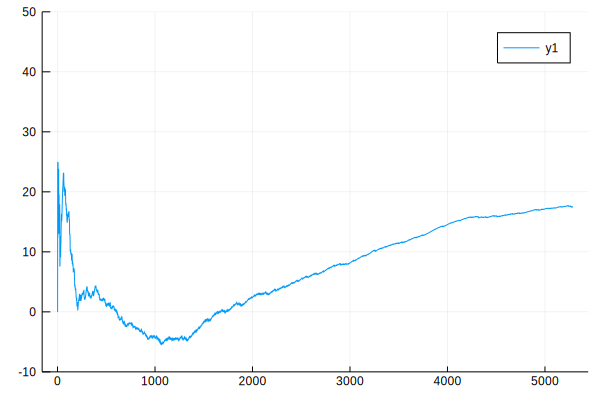

In [14]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-10,50))

In [10]:
#θ = convert(Matrix, CSV.read("good.csv"))


28080×6 Array{Float64,2}:
  0.106108  0.0  -0.0829134  0.0   0.0743955  0.0
 -0.218553  0.0  -1.1224     0.0  -0.0545906  0.0
  0.326478  0.0  -1.73706    0.0  -0.277184   0.0
  0.908624  0.0  -1.52726    0.0   0.388403   0.0
  0.697881  0.0   0.670758   0.0   0.861652   0.0
 -0.10886   0.0  -1.74887    0.0   0.265702   0.0
  0.375173  0.0   1.65491    0.0   0.651283   0.0
  1.15377   0.0   6.51786    0.0   1.21614    0.0
  1.19869   0.0   5.65495    0.0  -0.0774921  0.0
  3.01445   0.0   9.6408     0.0  -0.425889   0.0
  4.68788   0.0   7.16558    0.0   1.04943    0.0
  4.66821   0.0   3.13691    0.0   1.33348    0.0
  6.16342   0.0   2.09777    0.0   1.28498    0.0
  ⋮                                           ⋮  
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0        0.0   0.0        0.0
  0.0       0.0   0.0   

In [18]:
θ = convert(Matrix, thetaframe)

28080×6 Array{Float64,2}:
 -1.77704    0.0  -3.91139    0.0  -1.6716    0.0
  0.104306   0.0  -0.277353   0.0   0.29317   0.0
  0.0992801  0.0   2.52568    0.0   1.46481   0.0
  0.892081   0.0   2.81689    0.0   1.36093   0.0
  0.633067   0.0   0.479396   0.0   0.563874  0.0
  1.14868    0.0   0.109032   0.0   0.678002  0.0
  0.651611   0.0  -0.0357058  0.0   0.760664  0.0
  1.14689    0.0   1.85016    0.0   0.111559  0.0
  1.16463    0.0   0.581399   0.0   0.865836  0.0
  1.1367     0.0   1.04617    0.0   1.66769   0.0
  0.345221   0.0   0.929168   0.0   0.788199  0.0
  0.681581   0.0   1.02612    0.0   0.704559  0.0
  0.978036   0.0   0.321273   0.0   1.28954   0.0
  ⋮                                           ⋮  
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0        0.0   0.0       0.0
  0.0        0.0   0.0  

In [25]:
thetaframe = DataFrame(θ)
CSV.write("0.44_theta_11.28_1", thetaframe)

"0.44_theta_11.28_1"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5